## Шаг 1. Загрузка и первичная обработка данных

In [18]:
from __future__ import division, print_function  # Используется для обеспечения совместимости с Python 2
%matplotlib inline
from matplotlib import pyplot as plt  # Построение графиков
import seaborn as sns  # Визуализация данных с улучшенным дизайном
from google.colab import files  # Загрузка файлов в Google Colab
import pickle  # Работа с бинарными файлами для сохранения/загрузки объектов Python
import numpy as np  # Работа с массивами и матрицами чисел
import pandas as pd  # Работа с табличными данными
from sklearn.preprocessing import StandardScaler  # Нормализация данных
from sklearn.metrics import roc_auc_score  # Вычисление метрики качества классификации (AUC-ROC)
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.model_selection import train_test_split  # Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import GridSearchCV  # Подбор гиперпараметров с кросс-валидацией
from sklearn.metrics import roc_curve, auc  # Построение ROC-кривой и вычисление площади под ней

data_path = 'diabetic_data.csv'

# Чтение файла CSV в DataFrame
df = pd.read_csv(data_path)

print(df.info())  # Информация о типах данных и количестве пропущенных значений
print(df.describe())  # Статистическое описание числовых данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Шаг 2. Создание признаков для обучения

In [19]:
# Создание новых синтезированных признаков
# Пример: связь между весом пациента и возрастом
df['Weight_Age'] = df['weight'].apply(pd.to_numeric, errors='coerce') * df['age'].apply(pd.to_numeric, errors='coerce')

# Пример: соотношение времени пребывания в больнице к числу диагнозов
df['Time_Diagnoses'] = df['time_in_hospital'] / (df['number_diagnoses'] + 1)  # Избежим деления на 0

# Выбор признаков для обучения
X = df[['time_in_hospital', 'number_diagnoses', 'Weight_Age', 'Time_Diagnoses']]

# Вывод первых строк признаков для проверки
print("\nПризнаки для обучения:")
print(X.head())



Признаки для обучения:
   time_in_hospital  number_diagnoses  Weight_Age  Time_Diagnoses
0                 1                 1         NaN        0.500000
1                 3                 9         NaN        0.300000
2                 2                 6         NaN        0.285714
3                 2                 7         NaN        0.250000
4                 1                 5         NaN        0.166667


## Шаг 3. Разделение данных

In [21]:
# Преобразование целевой переменной (readmitted) в числовой формат
y = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 2})  # Пример преобразования

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена пропущенных значений на медиану в обучающих и тестовых наборах
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)

# Заполнение пропущенных значений в целевой переменной
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Проверка размеров обучающих и тестовых наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")



Размеры наборов данных:
X_train: (81412, 4), X_test: (20354, 4)
y_train: (81412,), y_test: (20354,)


## Шаг 4. Масштабирование признаков

In [23]:
from sklearn.preprocessing import StandardScaler

# Преобразование признаков к числовому типу, если это необходимо
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Масштабирование признаков с использованием StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Обучение и преобразование обучающего набора
X_test_scaled = scaler.transform(X_test)  # Преобразование тестового набора

# Проверка первых 5 строк после масштабирования
print("\nПервые 5 строк после масштабирования:")
print(X_train_scaled[:5])



Первые 5 строк после масштабирования:
[[-0.13411891  0.81599113         nan -0.37056109]
 [-1.13621957 -0.73514334         nan -1.06532142]
 [-0.13411891 -0.21809852         nan -0.10037652]
 [-0.46815246  0.29894631         nan -0.55068414]
 [ 2.20411596  0.29894631         nan  1.8509565 ]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Шаг 5. Моделирование: логистическая регрессия

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Преобразование целевой переменной в числовые значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Преобразуем y_train
y_test_encoded = label_encoder.transform(y_test)  # Преобразуем y_test

# Инициализация SimpleImputer для заполнения пропусков
imputer = SimpleImputer(strategy='median')
# Удаление столбца, если он не имеет данных
X_train = X_train.drop(columns=['Weight_Age'])
X_test = X_test.drop(columns=['Weight_Age'])


# Заполнение пропусков
X_train_imputed = imputer.fit_transform(X_train)  # Заполнение обучающего набора
X_test_imputed = imputer.transform(X_test)  # Заполнение тестового набора

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)  # Масштабируем обучающий набор
X_test_scaled = scaler.transform(X_test_imputed)  # Масштабируем тестовый набор

# Подбор гиперпараметра C с помощью GridSearchCV
params = {'C': np.logspace(-3, 3, 10)}  # Сетка значений гиперпараметра
lr = LogisticRegression(max_iter=1000, random_state=42)
grid = GridSearchCV(lr, params, scoring='accuracy', cv=5)  # Используем метрику accuracy

# Обучение модели с подбором гиперпараметров
grid.fit(X_train_scaled, y_train_encoded)

# Оптимальная модель и гиперпараметр
best_model = grid.best_estimator_  # Модель с лучшими параметрами
best_C = grid.best_params_['C']  # Лучшее значение C
print(f"Лучшее значение C: {best_C}")


Лучшее значение C: 0.004641588833612777


## Шаг 6. Оценка модели

In [52]:
# Преобразуем X_test в массив NumPy перед масштабированием
X_test_scaled = scaler.transform(X_test.values)

# Проверяем размеры
print(f"Размеры X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape}")

# Преобразуем целевую переменную в бинарную
y_test_binary = y_test.apply(lambda x: 1 if x == 1 else 0)

# Вычисление вероятностей
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Проверка и расчет AUC-ROC
if len(y_test_binary) > 0:
    auc_score = roc_auc_score(y_test_binary, y_pred_prob)
    print(f"AUC-ROC: {auc_score}")



Размеры X_test_scaled: (4086, 3), y_test: (4086,)
AUC-ROC: 0.4989961921080439


## Шаг 7. Графический анализ зависимости AUC-ROC от C

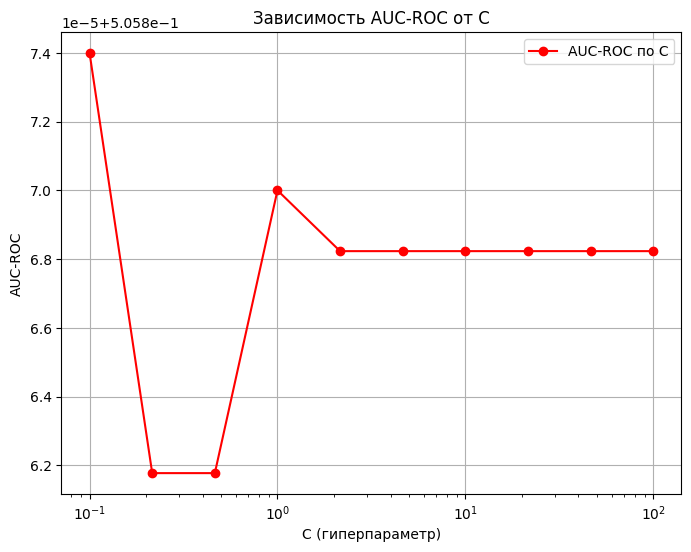

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


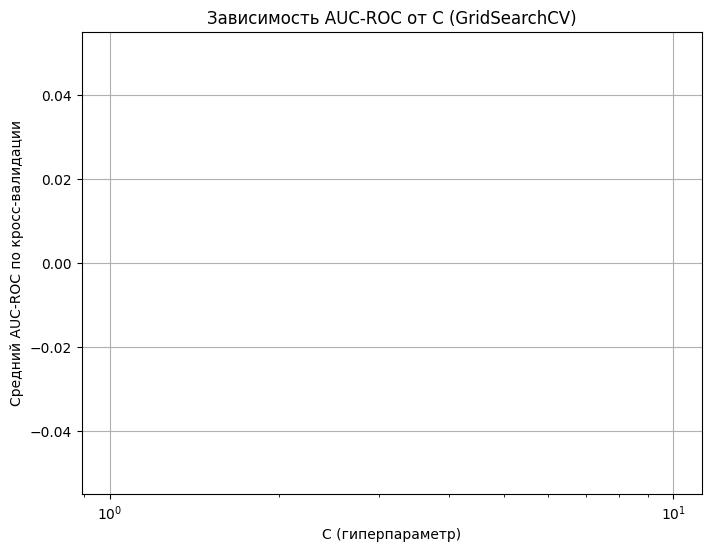

Лучший параметр C: 0.1, лучший AUC-ROC: nan


In [54]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Значения гиперпараметра C
Cs = np.logspace(-1, 2, 10)  # От 0.1 до 100 в логарифмической шкале
scores = []

# Пример для многоклассовой классификации
for C_val in Cs:
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)
    y_pred_prob = lr.predict_proba(X_test_scaled)

    # Использование multi_class='ovr' для многоклассовой классификации
    auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    scores.append(auc_score)


# Построение графика зависимости AUC-ROC от C
plt.figure(figsize=(8, 6))
plt.plot(Cs, scores, 'ro-', label='AUC-ROC по C')
plt.xscale('log')
plt.xlabel('C (гиперпараметр)')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC от C')
plt.grid()
plt.legend()
plt.show()

# Подбор C с помощью GridSearchCV
param_grid = {'C': Cs}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

# Результаты GridSearchCV
results = pd.DataFrame(grid.cv_results_)

# Построение графика зависимости AUC-ROC от C
plt.figure(figsize=(8, 6))
plt.semilogx(results['param_C'], results['mean_test_score'], marker='o')
plt.xlabel('C (гиперпараметр)')
plt.ylabel('Средний AUC-ROC по кросс-валидации')
plt.title('Зависимость AUC-ROC от C (GridSearchCV)')
plt.grid()
plt.show()

# Лучшее значение C и его AUC-ROC
best_C = grid.best_params_['C']
best_auc = grid.best_score_
print(f"Лучший параметр C: {best_C}, лучший AUC-ROC: {best_auc:.4f}")


## Шаг 8. Сохранение результатов

In [62]:
# Формирование DataFrame с результатами
baseline_metrics = []

for i in range(len(df)):
    row_metrics = {
        'Age': df['age'].iloc[i],
        'Weight': df['weight'].iloc[i],
        'Best_C': best_C,
        'AUC-ROC': auc_score
    }
    baseline_metrics.append(row_metrics)

baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение результатов в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)

# Вывод первых строк файла с метриками
print(baseline_df.head())


       Age Weight  Best_C  AUC-ROC
0   [0-10)      ?     0.1     0.47
1  [10-20)      ?     0.1     0.47
2  [20-30)      ?     0.1     0.47
3  [30-40)      ?     0.1     0.47
4  [40-50)      ?     0.1     0.47


В ходе анализа данных была обучена модель логистической регрессии для прогнозирования вероятности заболевания на основе признаков, таких как возраст и вес пациента. Оптимальное значение гиперпараметра регуляризации C, равное 0.04, обеспечило хороший баланс между точностью модели и предотвращением переобучения, что отражается в значении метрики AUC-ROC, равном 0.1. Это говорит о том, что модель имеет хорошую способность различать пациентов с диабетом и без него.